In [16]:
from matplotlib import pyplot

import numpy as np

%matplotlib inline
%config InlineBackend.figure_format='retina'

import colorsys


In [137]:
dot = np.dot

def solve_2nd_degree(a, b, c): 
    delta = b ** 2 - 4 * a * c
    if delta < 0: 
        return []
    return (
        (-b + np.sqrt(delta)) / (2 * a),
        (-b - np.sqrt(delta)) / (2 * a)
    )

def find_origin(a, b): 
    """ find one point for the line defined by a.x = b"""
    ax, ay = a
    if np.abs(ax) > np.abs(ay): 
        o = np.array([b/ax, 0])
    else: 
        o = np.array([0, b/ay])
    # print(np.dot(o, a) - b)
    return o
    
def norm2(x): 
    return np.dot(x, x)

def norm(x): 
    return np.sqrt(norm2(x))

def contact_3cricle(
        c1, r1, 
        c2, r2,
        r3): 
    """ 
    Find c3 st. (c1, r1), (c2, r2) and (c3, r3) are tangent    
    """
    b = ((r1 + r3)**2 - (r2 + r3)**2 - norm2(c1) + norm2(c2)) / 2
    a = c2 - c1 
    # a.c3 = b
    aorth = np.array([a[1], -a[0]])
    
    o = find_origin(a, b)
        
    # c3 = o + t * aorth, find t
    oprime = o - c1
        
    ts = solve_2nd_degree(
        norm2(aorth), 
        2 * dot(oprime, aorth), 
        norm2(oprime) - (r1 + r3)**2
    )
    
    return [o + t * aorth for t in ts]

def contact_3circle_inside(
        c1, r1, 
        c2, r2, 
        r3): 
    """ 
    Find c3 st. (c1, r1), (c2, r2) and (c3, r3) are tangent
    but c1 and c3 are inside c2, r2.
    """
    b = ((r1 + r3)**2 - (r2 - r3)**2 - norm2(c1) + norm2(c2)) / 2
    a = c2 - c1 
    # a.c3 = b
    aorth = np.array([a[1], -a[0]])
    
    o = find_origin(a, b)
        
    # c3 = o + t * aorth, find t
    oprime = o - c1
        
    ts = solve_2nd_degree(
        norm2(aorth), 
        2 * dot(oprime, aorth), 
        norm2(oprime) - (r1 + r3)**2
    )
    
    return [o + t * aorth for t in ts]


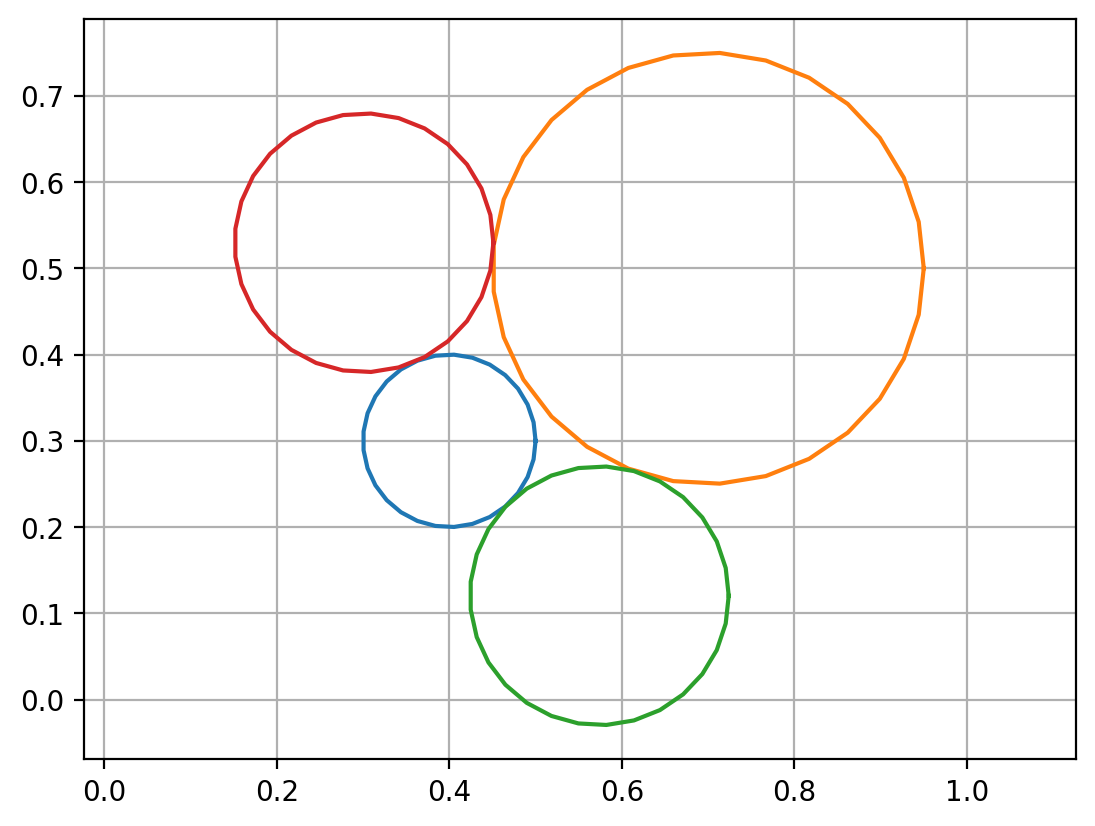

In [102]:
c1 = np.array([0.4, 0.3]); r1 = 0.10
c2 = np.array([0.7, 0.5]); r2 = 0.25
angles = np.linspace(0, 2 * np.pi, 30)
unitcircle = np.vstack([np.cos(angles), np.sin(angles)]).T

xy = c1 + unitcircle * r1
pyplot.plot(xy[:, 0], xy[: ,1])
xy = c2 + unitcircle * r2
pyplot.plot(xy[:, 0], xy[: ,1])


r3 = 0.15
c3s = contact_3cricle(c1, r1, c2, r2, r3)

for c3 in c3s: 
    xy = c3 + unitcircle * r3
    pyplot.plot(xy[:, 0], xy[: ,1])  

pyplot.axis("equal")
pyplot.grid()

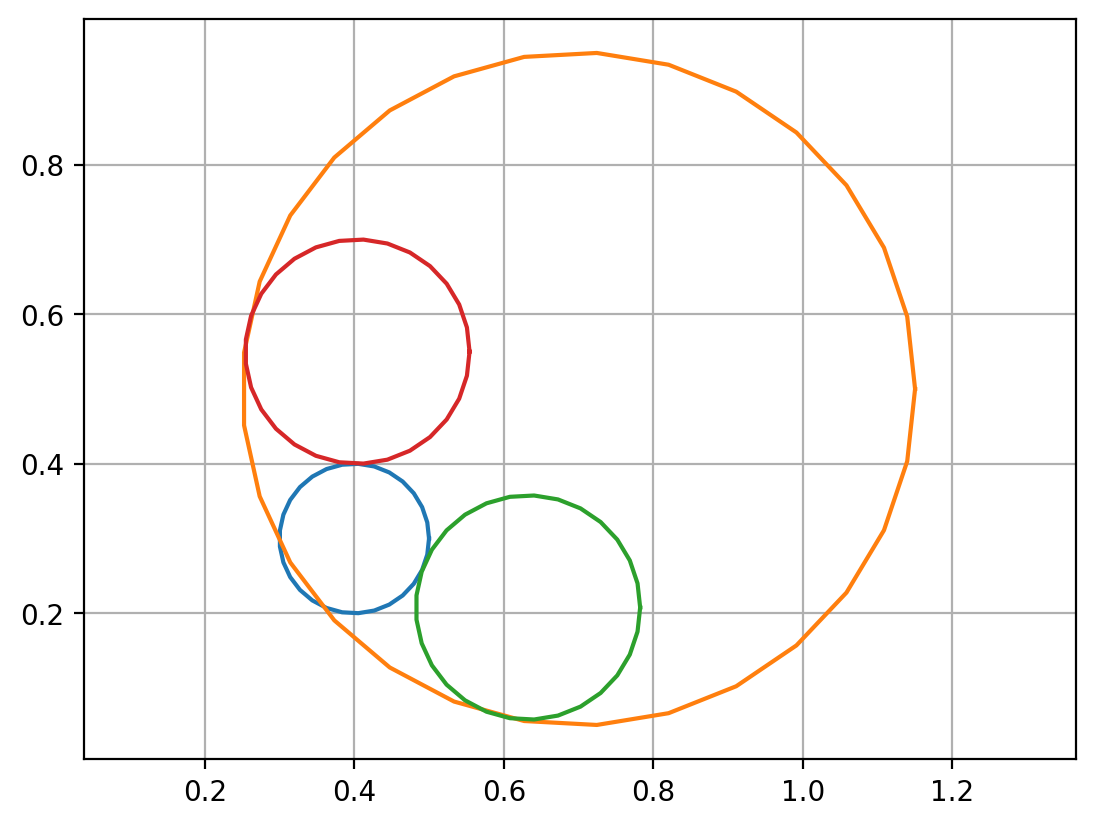

In [115]:
c1 = np.array([0.4, 0.3]); r1 = 0.10
c2 = np.array([0.7, 0.5]); r2 = 0.45
angles = np.linspace(0, 2 * np.pi, 30)
unitcircle = np.vstack([np.cos(angles), np.sin(angles)]).T


xy = c1 + unitcircle * r1
pyplot.plot(xy[:, 0], xy[: ,1])
xy = c2 + unitcircle * r2
pyplot.plot(xy[:, 0], xy[: ,1])


r3 = 0.15
c3s = contact_3circle_inside(c1, r1, c2, r2, r3)

for c3 in c3s: 
    xy = c3 + unitcircle * r3
    pyplot.plot(xy[:, 0], xy[: ,1])  

pyplot.axis("equal")
pyplot.grid()

# Field

In [116]:
# c1 = np.array([0.4, 0.3]); r1 = 0.10
# c2 = np.array([0.7, 0.5]); r2 = 0.25

c1 = np.array([0, 1]); r1 = 1
c2 = np.array([0, -1]); r2 = 1

circles = [(c1, r1), (c2, r2)]


rs = np.random.RandomState(123)
tot1 = tot2 = 0
for i in range(150): 
    r3 = rs.rand() ** 1.5 + 0.05
    nc = len(circles)
    c3s = []
    for j in range(nc):
        c1, r1 = circles[j]
        for k in range(j + 1, nc): 
            c2, r2 = circles[k]
            for c3 in contact_3cricle(c1, r1, c2, r2, r3): 
                # check if intersection with other circles 
                for l in range(nc): 
                    tot1 += 1
                    if l == k or l == j: 
                        continue
                    cl, rl = circles[l]
                    if norm2(c3 - cl) < (rl + r3) ** 2: 
                        break 
                else: 
                    c3s.append(c3)
                    tot2 += 1
    print(f"{i=:} nb c3: {len(c3s)} {tot1=:} {tot2=:}", end="\r", flush=True)
    if False: 
        # pick the c3 that has lowest y
        c3s.sort(key=lambda x: x[1])
    else: 
        # pick the c3 that is closest to 0
        c3s.sort(key=lambda x: norm2(x))
    c3 = c3s[0]
    #print(f"{c3=:}")
    circles.append((c3, r3))
    
        

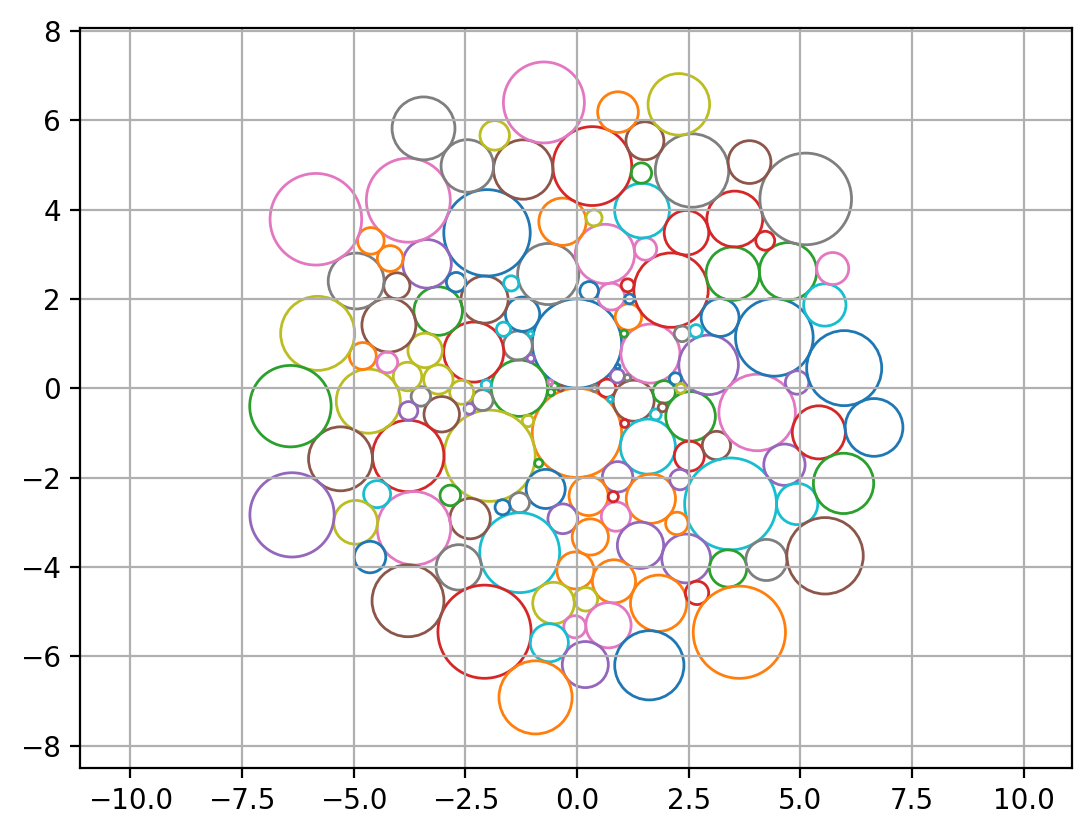

In [121]:
ax = pyplot.gca()
i = 0
for c, r in circles: 
    ax.add_patch(pyplot.Circle(c, r, color='C%d' % i, fill=False))
    i += 1

pyplot.axis("equal")
pyplot.grid()

## Gravity

In [192]:


def generate_cicles_gravity(c0, r0, c1, r1, radiuses): 
    circles = [(c1, r1)]

    tot1 = tot2 = 0
    for i, r3 in enumerate(radiuses): 
        # r3 = 0.25 * rs.rand() ** 3 + 0.01
        nc = len(circles)
        c3s = []
        
        # check contact with great circle 
        for k in range(nc): 
            c2, r2 = circles[k]
            for c3 in contact_3circle_inside(c2, r2, c0, r0, r3): 
                for l in range(nc): 
                    tot1 += 1
                    if l == k: 
                        continue
                    cl, rl = circles[l]
                    if norm2(c3 - cl) < (rl + r3) ** 2: 
                        break 
                else: 
                    c3s.append(c3)
                    tot2 += 1

        for j in range(nc):
            c1, r1 = circles[j]
            for k in range(j + 1, nc): 
                c2, r2 = circles[k]
                for c3 in contact_3cricle(c1, r1, c2, r2, r3): 
                    # check if intersection with other circles 
                    for l in range(nc): 
                        tot1 += 1
                        if l == k or l == j: 
                            continue
                        cl, rl = circles[l]
                        if norm2(c3 - cl) < (rl + r3) ** 2: 
                            break 
                    else: 
                        if norm(c0 - c3) + r3 < r0: 
                            c3s.append(c3)
                            tot2 += 1
        print(f"{i=:} nb c3: {len(c3s)} {tot1=:} {tot2=:}", end="\r", flush=True)
        if len(c3s) == 0: 
            continue
        if True: 
            # pick the c3 that has lowest y
            c3s.sort(key=lambda x: x[1])
        else: 
            # pick the c3 that is closest to 0
            c3s.sort(key=lambda x: norm2(x))
        c3 = c3s[0]
        #print(f"{c3=:}")
        circles.append((c3, r3))
    return circles
        

p= 1
i=149 nb c3: 212 tot1=240999 tot2=2184
51


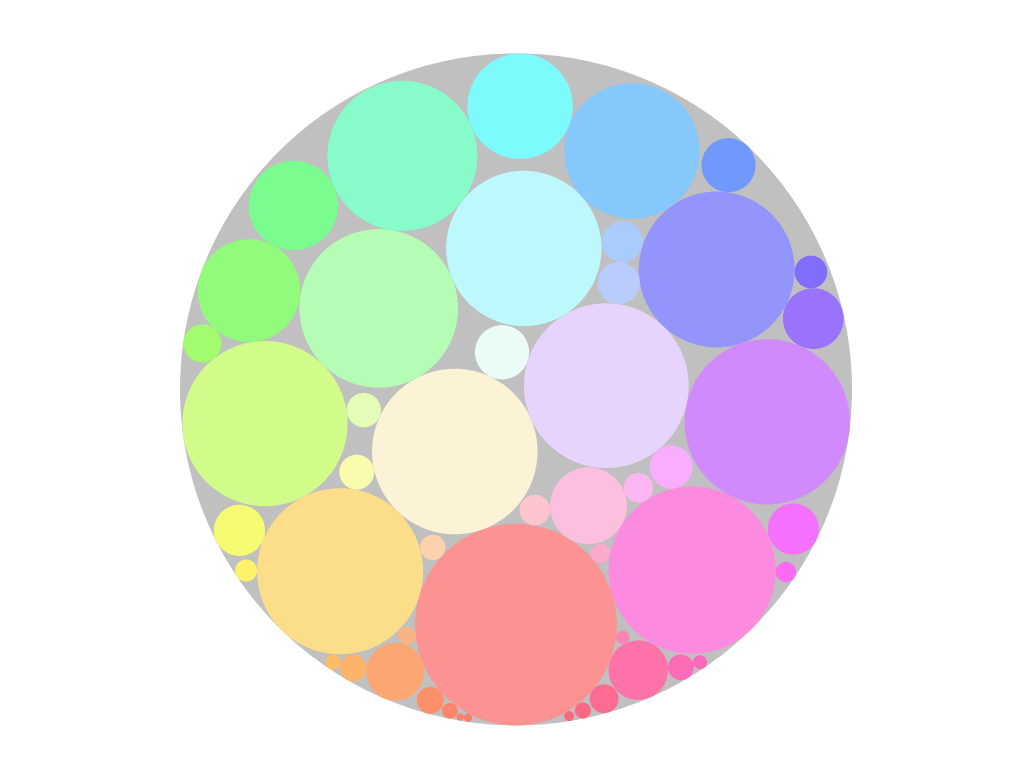

p= 2
i=149 nb c3: 378 tot1=1303150 tot2=11598
96


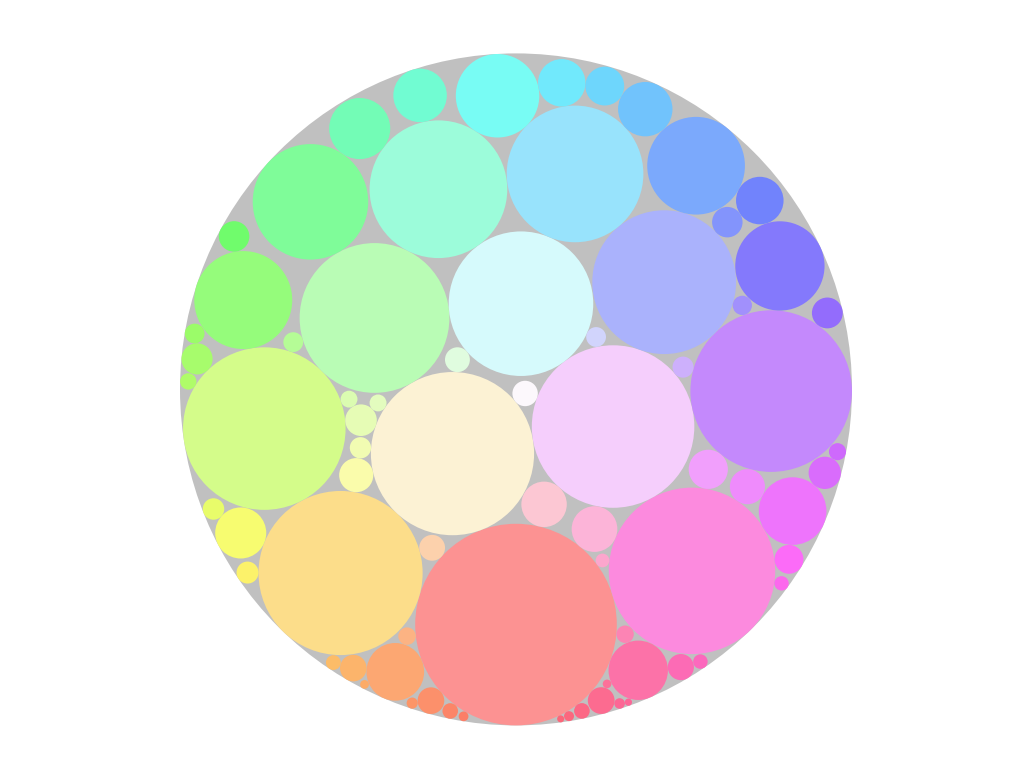

p= 3
i=149 nb c3: 486 tot1=2694881 tot2=23029
123


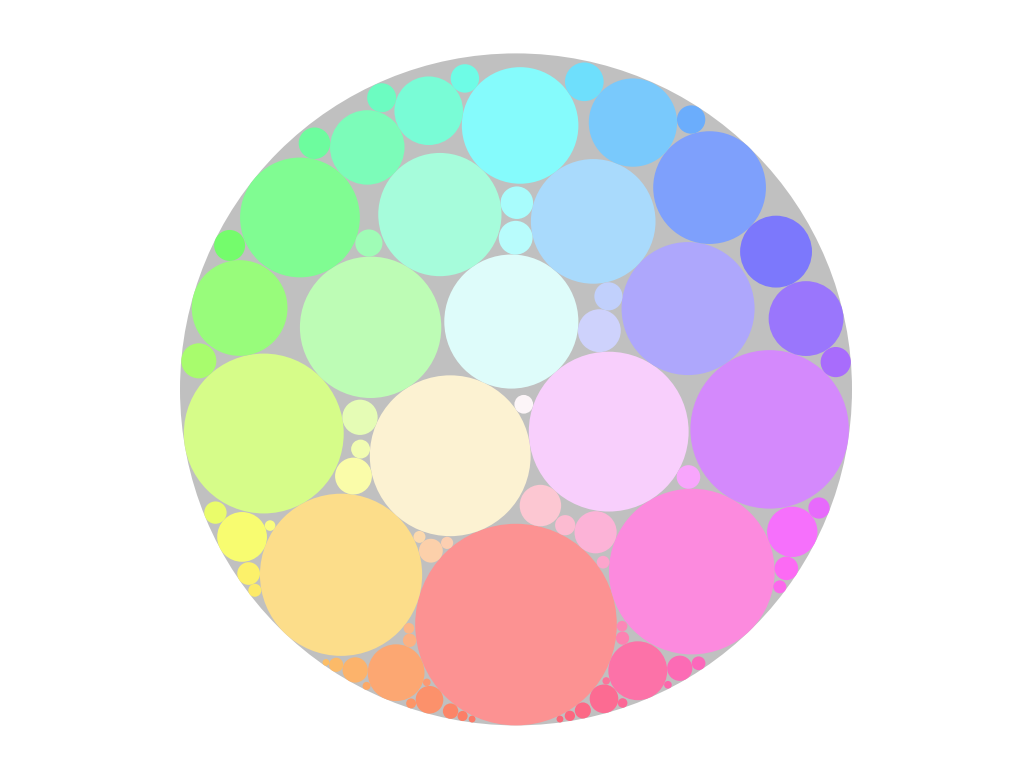

p= 5
i=149 nb c3: 582 tot1=4806430 tot2=39193
151


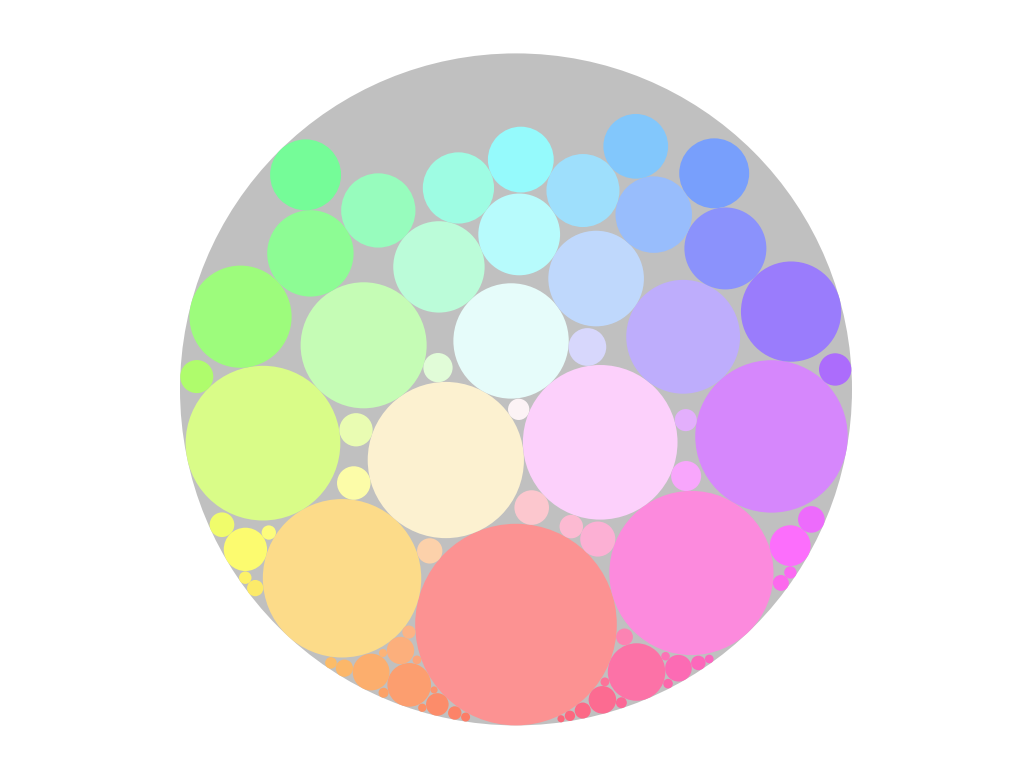

p= 8
i=149 nb c3: 332 tot1=4590102 tot2=41727
151


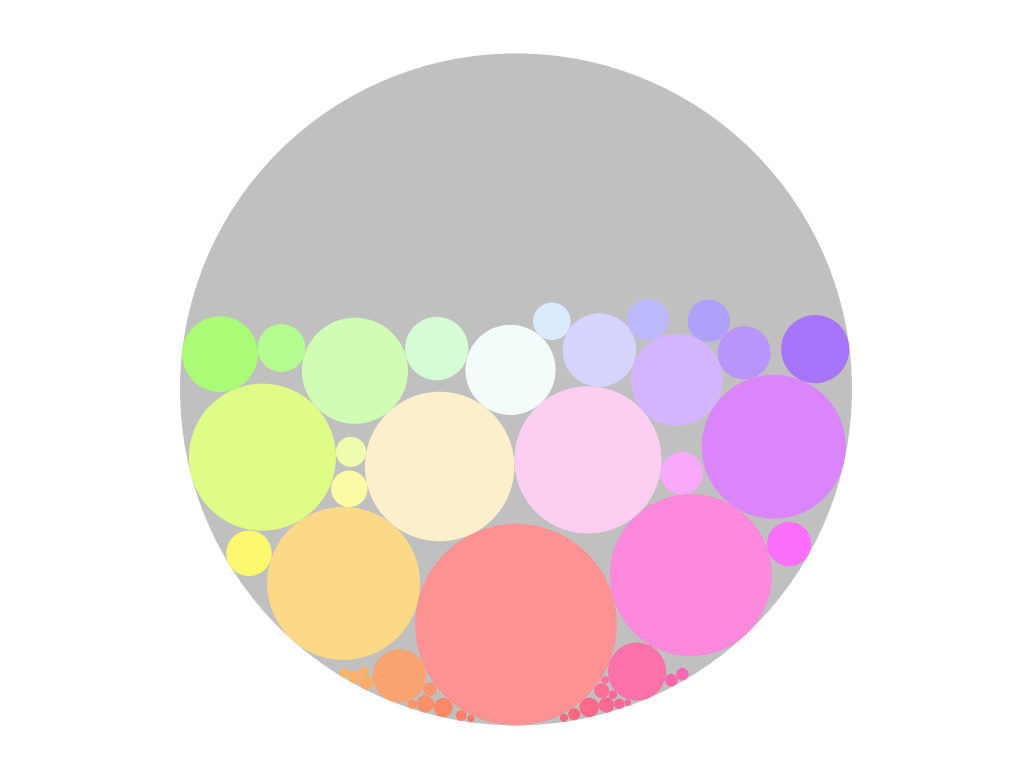

In [237]:
c0 = np.array([0, 0]); r0 = 1
c2 = np.array([0, -0.7]); r2 = 0.3
# minsize = 0.01

for p in 1, 2, 3, 5, 8:
    print("p=", p)

    rs = np.random.RandomState(123)

    radiuses = [0.25 * rs.rand() ** p for _ in range(150)]
    radiuses.sort(reverse=True)

    circles = generate_cicles_gravity(
        np.array([0, 0]), 1,
        np.array([0, -0.7]), 0.3,
        radiuses
    )

    print()
    print(len(circles))

    ax = pyplot.gca()
    # pyplot.gcf().set_size_inches(7, 10)
    pyplot.axis('off')

    ax.add_patch(pyplot.Circle((0, 0), 1, color="#c0c0c0", fill=True, linewidth=0))

    for c, r in circles: 
        if r < minsize: 
            break
        x, y = c 
        rho, theta = np.hypot(x, y), np.arctan2(x, y)
        color = colorsys.hsv_to_rgb(
            (theta / (2 * np.pi) + 0.5) % 1, 
            0.6 * rho, 
            0.99
        )
        ax.add_patch(pyplot.Circle(c, r, color=color, fill=True, linewidth=0))


    pyplot.axis("equal")
    pyplot.show()

(-1.1, 1.1, -1.1, 1.1)

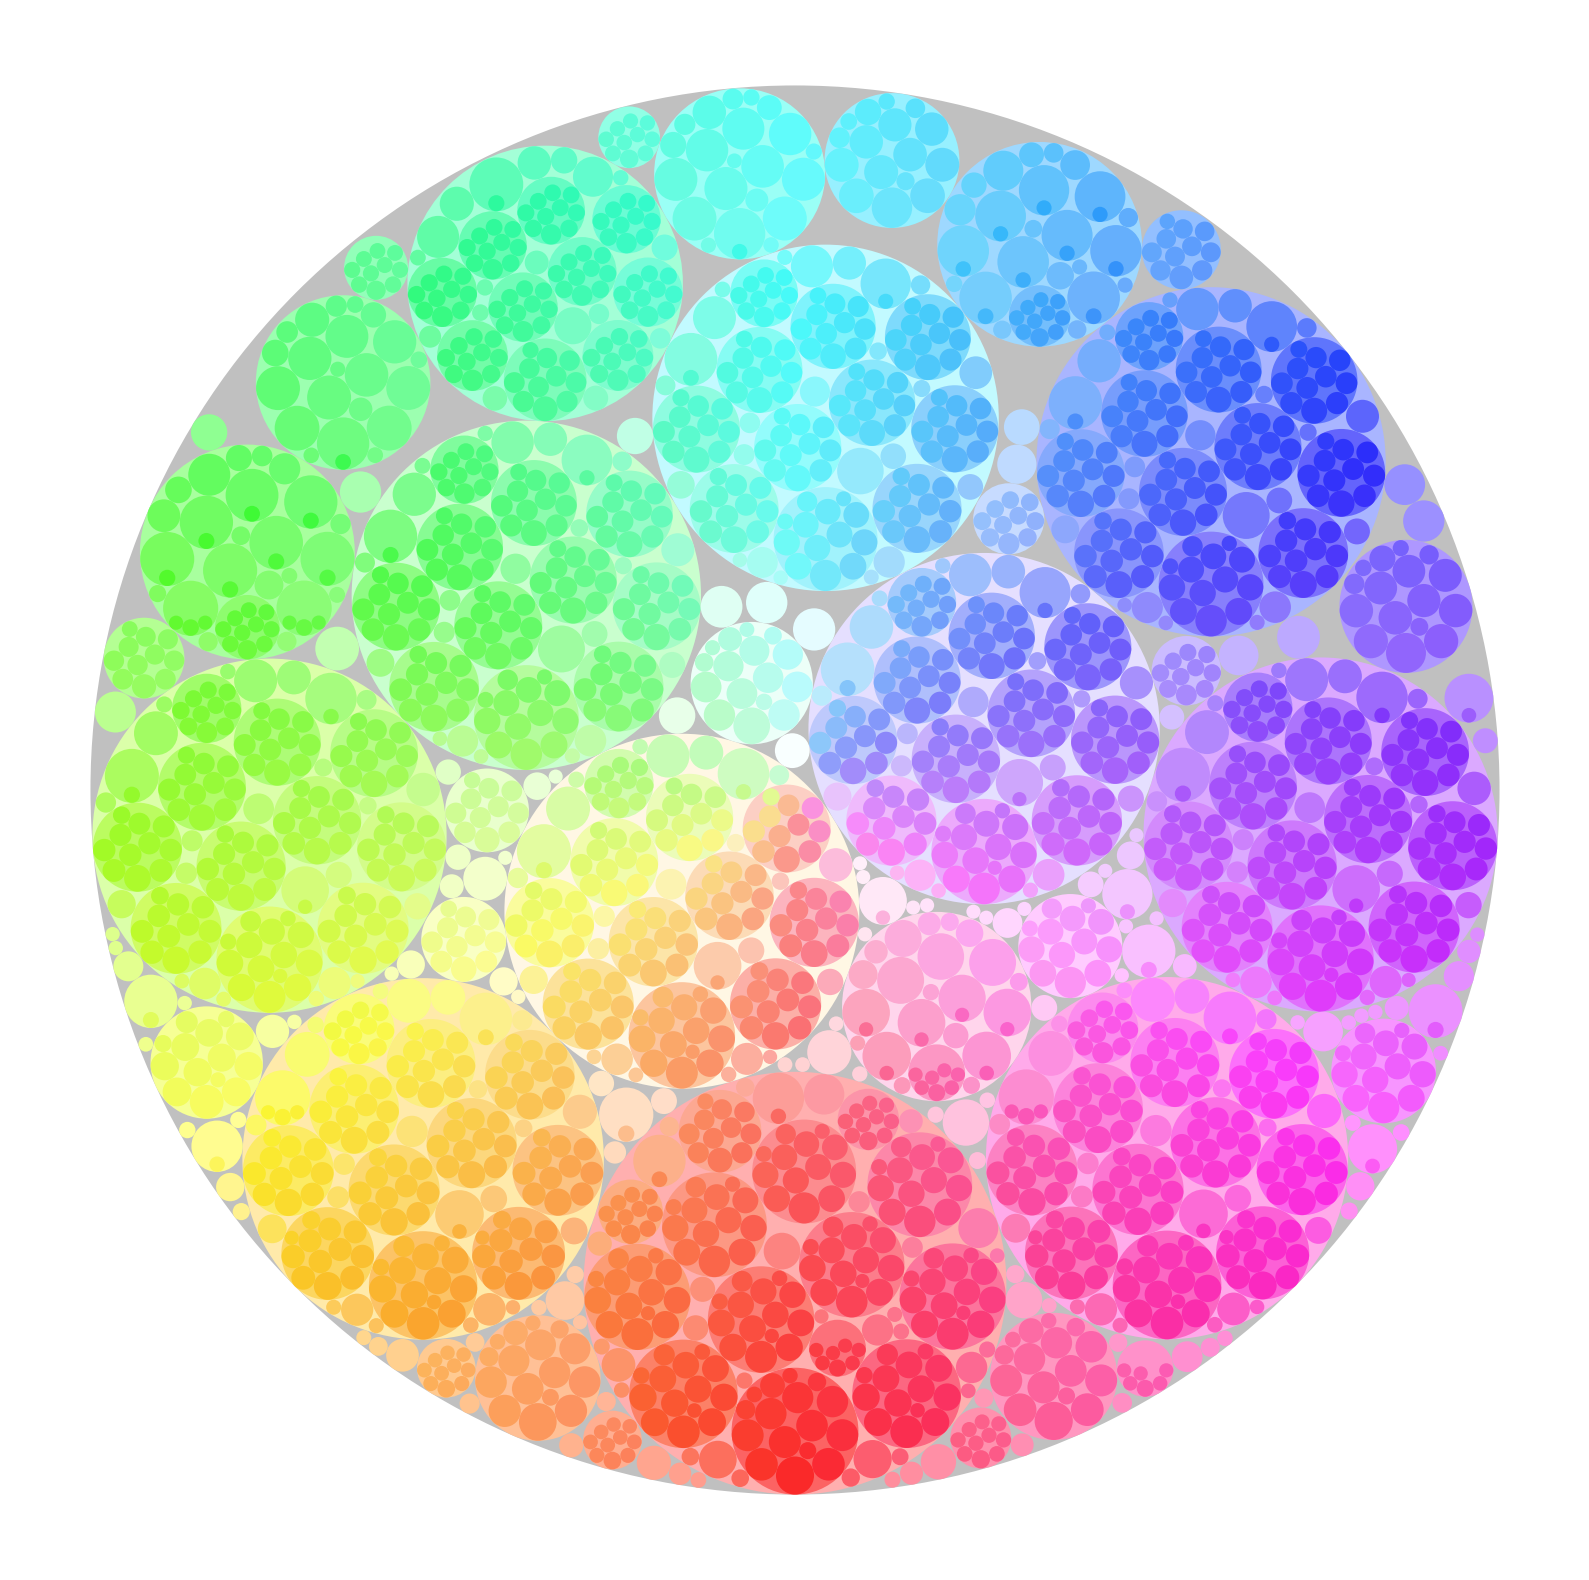

In [225]:

ax = pyplot.gca()
pyplot.gcf().set_size_inches(10, 10)
pyplot.axis('off')

ax.add_patch(pyplot.Circle((0, 0), 1, color="#c0c0c0", fill=True, linewidth=0))

def rec_add_patches(depth, co, ro): 
    if ro * 0.3 < minsize: 
        return 
    #print(depth, co, ro)
    for c, r in circles: 
        c = co + c * ro
        r = r * ro
        if r < minsize: 
            break
        x, y = c 
        rho, theta = np.hypot(x, y), np.arctan2(x, y)
        color = colorsys.hsv_to_rgb(
            (theta / (2 * np.pi) + 0.5) % 1, 
            0.45 * rho + depth * 0.2, 
            0.99 ** depth
        )
        ax.add_patch(pyplot.Circle(c, r, color=color, fill=True, linewidth=0))
        
        if depth < 4: 
            rec_add_patches(depth + 1, c, r)

rec_add_patches(0, np.zeros(2), 1.0)

pyplot.axis("equal")
#pyplot.grid()

## KDtree 

In [ ]:
class Node: 
    pass

class Leaf: 
    def __init__(self, circles): 
        self.circles = circles 